DATASET: FASHION MNIST

In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

#dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Matplotlib is building the font cache; this may take a moment.


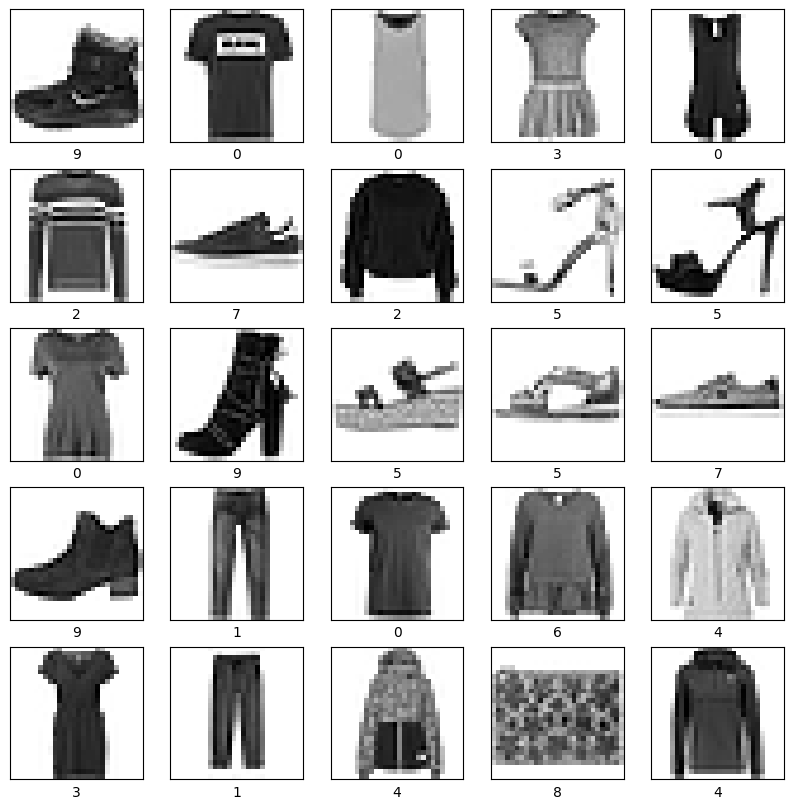

In [ ]:
#Display the dataset images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()


NORMALIZING IMAGES

In [2]:
#normalizing to 0-1
train_images = train_images / 255.0
test_images = test_images / 255.0

#expanding dimensions
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

METHOD: DEEP METRIC LEARNING (SIAMESE NETWORK)

In [ ]:
def create_pairs(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs = []
    labels_pairs = []
    min_samples = min(len(digit_indices[d]) for d in range(10)) - 1
    for d in range(10):
        for i in range(min_samples):
            # Positive pair
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs.append([images[z1], images[z2]])
            labels_pairs.append(1)
            # Negative pair
            inc = (d + 1) % 10
            z1, z2 = digit_indices[d][i], digit_indices[inc][i]
            pairs.append([images[z1], images[z2]])
            labels_pairs.append(0)
    return np.array(pairs), np.array(labels_pairs)

# Create pairs for the image and labels
train_pairs, train_pair_labels = create_pairs(train_images, train_labels)
test_pairs, test_pair_labels = create_pairs(test_images, test_labels)

from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

input_shape = (28, 28, 1)

def create_base_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3,3), activation='relu')(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return models.Model(input, x)

base_network = create_base_network(input_shape)

# Inputs for the pairs
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

# Process inputs through the base network
processed_a = base_network(input_a)
processed_b = base_network(input_b)

#Euclidean distance
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])

#Siamese network model
siamese_model = models.Model([input_a, input_b], distance)

#Loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

#Compile model
siamese_model.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])

# Train model
siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels,
    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_pair_labels),
    batch_size=128, epochs=10
)

# Extract embeddings
train_embeddings_siamese = base_network.predict(train_images)
test_embeddings_siamese = base_network.predict(test_images)



Epoch 1/10


/Users/ojasvasingh/Desktop/Shoppin_Assignment/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_7', 'keras_tensor_8']. Received: the structure of inputs=('*', '*')
  warnings.warn(


938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 90ms/step - accuracy: 0.0496 - loss: 0.0445 - val_accuracy: 0.0319 - val_loss: 0.0282
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - accuracy: 0.0225 - loss: 0.0231 - val_accuracy: 0.0290 - val_loss: 0.0263
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 90s 96ms/step - accuracy: 0.0176 - loss: 0.0194 - val_accuracy: 0.0248 - val_loss: 0.0245
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - accuracy: 0.0126 - loss: 0.0162 - val_accuracy: 0.0266 - val_loss: 0.0249
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - accuracy: 0.0094 - loss: 0.0138 - val_accuracy: 0.0266 - val_loss: 0.0247
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - accuracy: 0.0081 - loss: 0.0124 - val_accuracy: 0.0275 - val_loss: 0.0248
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 94s 100ms/step - accuracy: 0.0062 - loss: 0.0107 - val_accuracy: 0.0266 - val_loss: 0.0250
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - accuracy: 0.0050 - loss: 0.0096 - val_accura

METHOD: HASHING-BASED METHODS

In [ ]:
import tensorflow as tf
import numpy as np

def create_hashing_network(input_shape, hash_bits):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    # Hash layer
    x = tf.keras.layers.Dense(hash_bits, activation='tanh')(x)
    model = tf.keras.Model(inputs, x)
    return model

hash_bits = 32
input_shape = (28, 28, 1)
hashing_model = create_hashing_network(input_shape, hash_bits)

# Create pairs for the image and labels
train_pairs, train_pair_labels = create_pairs(train_images, train_labels)

def hash_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, tf.float32)

    #Shape of y_pred
    hash_bits = tf.shape(y_pred)[1] // 2

    # Split y_pred into hash1 and hash2
    hash1 = y_pred[:, :hash_bits]
    hash2 = y_pred[:, hash_bits:]

    # Compute the distance
    distance = tf.reduce_sum(tf.square(hash1 - hash2), axis=1)

    # Compute the loss
    loss = y_true * distance + (1 - y_true) * tf.maximum(margin - distance, 0.0)
    return tf.reduce_mean(loss)

# Inputs for the pairs
input_1 = tf.keras.Input(shape=input_shape)
input_2 = tf.keras.Input(shape=input_shape)

# Process inputs through the hashing network
hash_code_1 = hashing_model(input_1)
hash_code_2 = hashing_model(input_2)

# Concatenate the hash codes
concatenated = tf.keras.layers.Concatenate(axis=1)([hash_code_1, hash_code_2])

# Define the model
hash_model = tf.keras.Model(inputs=[input_1, input_2], outputs=concatenated)

# Compile the model
hash_model.compile(optimizer='adam', loss=hash_loss)

# Train the model
hash_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels,
    batch_size=128, epochs=10
)


#Get hash codes for the train and test images
train_hash_codes = hashing_model.predict(train_images)
test_hash_codes = hashing_model.predict(test_images)

#Binarize the hash codes to 0 or 1
train_hash_codes_binary = (train_hash_codes > 0).astype(np.uint8)
test_hash_codes_binary = (test_hash_codes > 0).astype(np.uint8)


Epoch 1/10


/Users/ojasvasingh/Desktop/Shoppin_Assignment/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_23', 'keras_tensor_24']. Received: the structure of inputs=('*', '*')
  warnings.warn(


938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - loss: 0.0797
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - loss: 0.0386
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.0294
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - loss: 0.0225
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.0167
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.0132
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.0112
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 0.0090
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 0.0069
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 0.0060
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


METHOD: AUTOENCODER BASED IMAGE RECONSTRUCTION

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_images, train_images, epochs=10, batch_size=256, shuffle=True, validation_data=(test_images, test_images))

# Define the encoder model
encoder = Model(input_img, encoded)

# Extract features
train_encoded_imgs = encoder.predict(train_images)
test_encoded_imgs = encoder.predict(test_images)


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - loss: 0.3769 - val_loss: 0.2827
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - loss: 0.2783 - val_loss: 0.2755
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - loss: 0.2725 - val_loss: 0.2718
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - loss: 0.2689 - val_loss: 0.2694
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - loss: 0.2663 - val_loss: 0.2665
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 164ms/step - loss: 0.2640 - val_loss: 0.2678
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - loss: 0.2620 - val_loss: 0.2618
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - loss: 0.2597 - val_loss: 0.2605
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - loss: 0.2582 - val_loss: 0.2593
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 184ms/step - loss: 0.2574 - val_loss: 0.2583
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


CUSTOM CNN FEATURE EXTRACTION

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout

def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', name='embedding_layer')(x)  # Embedding layer
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)  # Classification layer
    
    model = Model(inputs, outputs)
    return model

input_shape = (28, 28, 1)
cnn_model = create_cnn_model(input_shape)

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=10,
    batch_size=128
)

# Create a model to output embeddings from the 'embedding_layer'
embedding_model = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('embedding_layer').output)

# Extract embeddings
train_embeddings_cnn = embedding_model.predict(train_images)
test_embeddings_cnn = embedding_model.predict(test_images)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.6695 - loss: 0.9286 - val_accuracy: 0.8470 - val_loss: 0.4190
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8421 - loss: 0.4466 - val_accuracy: 0.8701 - val_loss: 0.3571
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8629 - loss: 0.3786 - val_accuracy: 0.8834 - val_loss: 0.3266
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.8754 - loss: 0.3435 - val_accuracy: 0.8894 - val_loss: 0.3107
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8875 - loss: 0.3101 - val_accuracy: 0.8934 - val_loss: 0.2924
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8940 - loss: 0.2945 - val_accuracy: 0.8944 - val_loss: 0.2910
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9004 - loss: 0.2728 - val_accuracy: 0.9022 - val_loss: 0.2727
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9010 - loss: 0.2675 - 

METHOD: VARIATIONAL AUTOENCODER (VAE)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape,
    Conv2DTranspose, Lambda, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
latent_dim = 64  # Dimensionality of the latent space
input_shape = (28, 28, 1)  # Input shape for Fashion MNIST images

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize and reshape images
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0
train_images = np.expand_dims(train_images, -1)  # Add channel dimension
test_images = np.expand_dims(test_images, -1)

# Encoder model definition
def encoder_model(input_shape):
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    # Mean and log variance for latent variables
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    # Sampled latent vector
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    # Return the encoder model
    return Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder model definition
def decoder_model():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Return the decoder model
    return Model(latent_inputs, outputs, name='decoder')

# Custom layer for VAE loss
class VAELossLayer(Layer):
    def __init__(self, encoder, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.encoder = encoder

    def call(self, inputs):
        input_img, reconstructed_img = inputs
        
        # Compute reconstruction loss
        reconstruction_loss = tf.keras.losses.binary_crossentropy(
            tf.keras.backend.flatten(input_img),
            tf.keras.backend.flatten(reconstructed_img)
        )
        reconstruction_loss *= input_shape[0] * input_shape[1]  # Scale by image size
        
        # Compute KL divergence loss
        z_mean, z_log_var, _ = self.encoder(input_img)
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
        
        # Total VAE loss
        vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        
        # Add loss to the layer
        self.add_loss(vae_loss)
        return reconstructed_img

# Instantiate encoder and decoder
encoder = encoder_model(input_shape)
decoder = decoder_model()

# Define the VAE model
input_img = Input(shape=input_shape, name='input_img')
z_mean, z_log_var, z = encoder(input_img)
reconstructed_img = decoder(z)

# Add custom VAE loss layer
output_img = VAELossLayer(encoder)([input_img, reconstructed_img])

# Create the VAE model
vae = Model(inputs=input_img, outputs=output_img, name='vae')

# Compile the VAE model
vae.compile(optimizer='adam')

# Train the VAE model
vae.fit(
    train_images,
    epochs=10,
    batch_size=128,
    validation_data=(test_images, None)
)

# Extract embeddings (latent vectors) for training and testing data
# We use the encoder part of the VAE to get the latent representations
train_z_mean, train_z_log_var, train_z = encoder.predict(train_images, batch_size=128)
test_z_mean, test_z_log_var, test_z = encoder.predict(test_images, batch_size=128)

# The embeddings can be either z_mean or z (sampled z)
# For deterministic embeddings, it's common to use z_mean
train_embeddings_vae = train_z_mean
test_embeddings_vae = test_z_mean


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 114ms/step - loss: 359.4084 - val_loss: 271.4210
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 114ms/step - loss: 264.5897 - val_loss: 256.8626
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - loss: 253.4071 - val_loss: 250.8386
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - loss: 248.4861 - val_loss: 248.2143
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - loss: 246.2006 - val_loss: 246.8258
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - loss: 244.6436 - val_loss: 245.6139
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - loss: 243.5731 - val_loss: 244.6422
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 242.6531 - val_loss: 244.6104
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - loss: 241.8780 - val_loss: 243.1501
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 241.2486 - val_loss: 242.9801
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Cosine Similarity
def compute_cosine_similarity(query_embedding, embeddings):
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    return similarities

# Euclidean Distance
def compute_euclidean_distance(query_embedding, embeddings):
    distances = euclidean_distances([query_embedding], embeddings)[0]
    # Convert distances to similarities
    similarities = 1 / (1 + distances)
    return similarities

# Hamming Distance for Hash Codes
def compute_hamming_distance(query_code, codes):
    # XOR operation and sum
    distances = np.sum(np.bitwise_xor(query_code, codes), axis=1)
    # Convert distances to similarities
    similarities = 1 / (1 + distances)
    return similarities


In [9]:
def retrieve_top_k(query_embedding, embeddings, labels, k=5, metric='cosine'):
    if metric == 'cosine':
        similarities = compute_cosine_similarity(query_embedding, embeddings)
    elif metric == 'euclidean':
        similarities = compute_euclidean_distance(query_embedding, embeddings)
    else:
        raise ValueError("Unsupported metric")
    # Get top K indices
    indices = np.argsort(similarities)[::-1][:k]
    return indices, similarities[indices], labels[indices]


In [10]:
def retrieve_top_k_hash(query_code, codes, labels, k=5):
    similarities = compute_hamming_distance(query_code, codes)
    # Get top K indices
    indices = np.argsort(similarities)[::-1][:k]
    return indices, similarities[indices], labels[indices]


In [11]:
def compute_precision_at_k(query_label, retrieved_labels):
    relevant = np.sum(retrieved_labels == query_label)
    precision = relevant / len(retrieved_labels)
    return precision

def compute_recall_at_k(query_label, retrieved_labels, total_relevant):
    relevant = np.sum(retrieved_labels == query_label)
    recall = relevant / total_relevant
    return recall

def compute_retrieval_accuracy(query_label, retrieved_labels):
    return int(query_label in retrieved_labels)


In [12]:
def evaluate_method(test_embeddings, train_embeddings, train_labels, test_labels, k=5, metric='cosine', is_hash=False):
    precisions = []
    recalls = []
    accuracies = []
    total_relevant_per_class = {label: np.sum(train_labels == label) for label in np.unique(train_labels)}
    
    num_queries = len(test_embeddings)
    for i in range(num_queries):
        query_embedding = test_embeddings[i]
        query_label = test_labels[i]
        
        if is_hash:
            indices, similarities, retrieved_labels = retrieve_top_k_hash(query_embedding, train_embeddings, train_labels, k)
        else:
            indices, similarities, retrieved_labels = retrieve_top_k(query_embedding, train_embeddings, train_labels, k, metric)
        
        precision = compute_precision_at_k(query_label, retrieved_labels)
        recall = compute_recall_at_k(query_label, retrieved_labels, total_relevant_per_class[query_label])
        accuracy = compute_retrieval_accuracy(query_label, retrieved_labels)
        
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
    
    average_precision = np.mean(precisions)
    average_recall = np.mean(recalls)
    retrieval_accuracy = np.mean(accuracies)
    
    return average_precision, average_recall, retrieval_accuracy


In [13]:
import time

def measure_inference_time(model, data):
    start_time = time.time()
    embeddings = model.predict(data)
    end_time = time.time()
    inference_time = end_time - start_time
    return embeddings, inference_time

def measure_similarity_search_time(query_embeddings, database_embeddings, labels, k=5, metric='cosine', is_hash=False):
    start_time = time.time()
    for i in range(len(query_embeddings)):
        query_embedding = query_embeddings[i]
        if is_hash:
            retrieve_top_k_hash(query_embedding, database_embeddings, labels, k)
        else:
            retrieve_top_k(query_embedding, database_embeddings, labels, k, metric)
    end_time = time.time()
    search_time = end_time - start_time
    return search_time


In [ ]:
# Initialize a dictionary to store results
results = {}

# Parameters
k = 5  # Top K similar images
num_queries = 100  # Number of test images to use for evaluation

# Randomly select a subset of test images for faster evaluation
np.random.seed(42)
query_indices = np.random.choice(len(test_labels), num_queries, replace=False)

# Subset test embeddings and labels
test_indices = query_indices
test_labels_subset = test_labels[test_indices]

# 1. Deep Metric Learning (Siamese Network)
print("Evaluating Deep Metric Learning (Siamese Network)...")
test_embeddings = test_embeddings_siamese[test_indices]
train_embeddings = train_embeddings_siamese

# Measure inference time (embeddings are already computed)
search_time = measure_similarity_search_time(test_embeddings, train_embeddings, train_labels, k=k, metric='euclidean')
precision, recall, accuracy = evaluate_method(test_embeddings, train_embeddings, train_labels, test_labels_subset, k=k, metric='euclidean')

results['Siamese Network'] = {
    'Precision@K': precision,
    'Recall@K': recall,
    'Retrieval Accuracy': accuracy,
    'Search Time': search_time / num_queries  # Average time per query
}

# 2. Hashing-Based Method
print("Evaluating Hashing-Based Method...")
test_codes = test_hash_codes_binary[test_indices]
train_codes = train_hash_codes_binary

# Measure similarity search time
search_time = measure_similarity_search_time(test_codes, train_codes, train_labels, k=k, is_hash=True)
precision, recall, accuracy = evaluate_method(test_codes, train_codes, train_labels, test_labels_subset, k=k, is_hash=True)

results['Hashing-Based Method'] = {
    'Precision@K': precision,
    'Recall@K': recall,
    'Retrieval Accuracy': accuracy,
    'Search Time': search_time / num_queries
}

# 3. Autoencoder-Based Latent Space Mapping
print("Evaluating Autoencoder-Based Method...")
test_embeddings = test_encoded_imgs[test_indices].reshape(len(test_indices), -1)
train_embeddings = train_encoded_imgs.reshape(len(train_encoded_imgs), -1)

# Measure similarity search time
search_time = measure_similarity_search_time(test_embeddings, train_embeddings, train_labels, k=k, metric='euclidean')
precision, recall, accuracy = evaluate_method(test_embeddings, train_embeddings, train_labels, test_labels_subset, k=k, metric='euclidean')

results['Autoencoder'] = {
    'Precision@K': precision,
    'Recall@K': recall,
    'Retrieval Accuracy': accuracy,
    'Search Time': search_time / num_queries
}

# 4. Custom CNN Feature Extraction
print("Evaluating Custom CNN Feature Extraction...")
test_embeddings = test_embeddings_cnn[test_indices]
train_embeddings = train_embeddings_cnn

# Measure similarity search time
search_time = measure_similarity_search_time(test_embeddings, train_embeddings, train_labels, k=k, metric='cosine')
precision, recall, accuracy = evaluate_method(test_embeddings, train_embeddings, train_labels, test_labels_subset, k=k, metric='cosine')

results['Custom CNN'] = {
    'Precision@K': precision,
    'Recall@K': recall,
    'Retrieval Accuracy': accuracy,
    'Search Time': search_time / num_queries
}

# 5. Variational Autoencoder
print("Evaluating Variational Autoencoder...")
test_embeddings = test_embeddings_vae[test_indices]
train_embeddings = train_embeddings_vae

# Measure similarity search time
search_time = measure_similarity_search_time(test_embeddings, train_embeddings, train_labels, k=k, metric='cosine')
precision, recall, accuracy = evaluate_method(test_embeddings, train_embeddings, train_labels=train_labels, test_labels=test_labels_subset, k=k, metric='cosine')

results['Variational Autoencoder'] = {
    'Precision@K': precision,
    'Recall@K': recall,
    'Retrieval Accuracy': accuracy,
    'Search Time': search_time / num_queries
}


Evaluating Deep Metric Learning (Siamese Network)...
Evaluating Hashing-Based Method...
Evaluating Autoencoder-Based Method...
Evaluating Custom CNN Feature Extraction...
Evaluating Variational Autoencoder...


In [35]:
# Display the results
import pandas as pd

df_results = pd.DataFrame(results).T
print(df_results)

                         Precision@K  Recall@K  Retrieval Accuracy  \
Siamese Network                0.568  0.000473                0.84   
Hashing-Based Method           0.294  0.000245                0.82   
Autoencoder                    0.826  0.000688                0.96   
Custom CNN                     0.908  0.000757                0.96   
Variational Autoencoder        0.816  0.000680                0.96   

                         Search Time  
Siamese Network             0.011798  
Hashing-Based Method        0.002420  
Autoencoder                 0.361875  
Custom CNN                  0.012513  
Variational Autoencoder     0.008397  


In [37]:
from tabulate import tabulate

print(tabulate(df_results, headers='keys', tablefmt='pretty'))

+-------------------------+---------------------+------------------------+--------------------+----------------------+
|                         |     Precision@K     |        Recall@K        | Retrieval Accuracy |     Search Time      |
+-------------------------+---------------------+------------------------+--------------------+----------------------+
|     Siamese Network     |        0.568        | 0.00047333333333333336 |        0.84        | 0.011797528266906738 |
|  Hashing-Based Method   | 0.29399999999999993 | 0.00024500000000000005 |        0.82        | 0.002420353889465332 |
|       Autoencoder       |        0.826        | 0.0006883333333333335  |        0.96        | 0.36187545776367186  |
|       Custom CNN        | 0.9080000000000001  | 0.0007566666666666669  |        0.96        | 0.012512509822845458 |
| Variational Autoencoder |        0.816        | 0.0006800000000000004  |        0.96        | 0.008396618366241455 |
+-------------------------+---------------------

FINAL RESULT OF THE BEST METHOD OUT OF THE 5 

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6732 - loss: 0.9318 - val_accuracy: 0.8449 - val_loss: 0.4258
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8407 - loss: 0.4486 - val_accuracy: 0.8673 - val_loss: 0.3659
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8637 - loss: 0.3785 - val_accuracy: 0.8787 - val_loss: 0.3304
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8767 - loss: 0.3433 - val_accuracy: 0.8863 - val_loss: 0.3135
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8846 - loss: 0.3194 - val_accuracy: 0.8936 - val_loss: 0.2923
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8933 - loss: 0.2954 - val_accuracy: 0.9005 - val_loss: 0.2803
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8980 - loss: 0.2773 - val_accuracy: 0.9038 - val_loss: 0.2711
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9028 - loss: 0.2631 - v

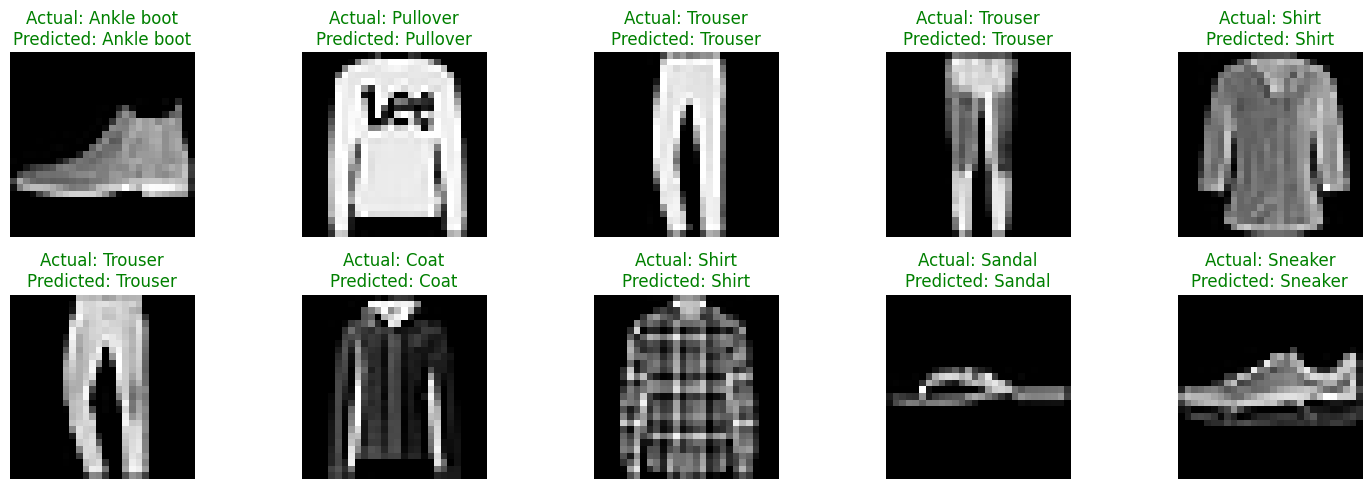

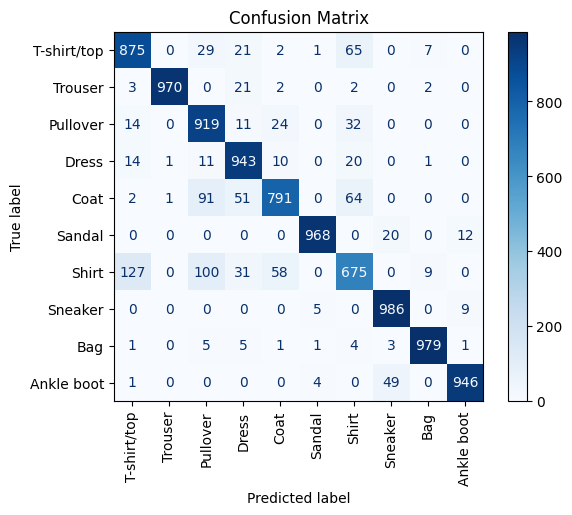

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.88      0.86      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.80      0.92      0.85      1000
       Dress       0.87      0.94      0.91      1000
        Coat       0.89      0.79      0.84      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.78      0.68      0.73      1000
     Sneaker       0.93      0.99      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.90     10000
weighted avg       0.91      0.91      0.90     10000



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize images to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Expand dimensions to include the channel dimension (grayscale)
train_images = train_images[..., tf.newaxis]  # Shape: (num_samples, 28, 28, 1)
test_images = test_images[..., tf.newaxis]

def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', name='embedding_layer')(x)  # Embedding layer
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)  # Classification layer
    
    model = Model(inputs, outputs)
    return model

input_shape = (28, 28, 1)
cnn_model = create_cnn_model(input_shape)

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=10,
    batch_size=128
)

# Create a model to output embeddings from the 'embedding_layer'
embedding_model = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('embedding_layer').output)

# Extract embeddings
train_embeddings_cnn = embedding_model.predict(train_images)
test_embeddings_cnn = embedding_model.predict(test_images)

# Map class indices to class names for better readability
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Use the trained CNN model to predict the classes of the test images
test_predictions = cnn_model.predict(test_images)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Function to plot images with actual and predicted labels
def plot_predictions(images, labels, predictions, class_names, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        actual_label = class_names[labels[i]]
        predicted_label = class_names[predictions[i]]
        color = 'green' if labels[i] == predictions[i] else 'red'
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the first 10 test images with their actual and predicted labels
plot_predictions(test_images, test_labels, test_predicted_labels, class_names, num_images=10)

#Plot confusion matrix
cm = confusion_matrix(test_labels, test_predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

#Print classification report
report = classification_report(test_labels, test_predicted_labels, target_names=class_names)
print(report)
